# CS 152—Assignment 4
Mohamed Emish

Professor Neil Rhodes


### Import libraries and initialize notebook

In [ ]:
# Install TensorFlow
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
!pip install gast==0.2.2 # downgrade to resolve a problem with tf and gast 0.3
import tensorflow as tf
print(tf.__version__)
print(tf.keras.__version__)

2.0.0
2.2.4-tf


In [ ]:
try: 
  import wget,  tarfile, matplotlib
except:
  !pip3 install wget
  !pip3 install tarfile
  !pip3 install matplotlib
  import wget, tarfile, matplotlib


### Prepare the Data

Downlaod files and unzip them

In [ ]:
imagenette_160 = wget.download('https://s3.amazonaws.com/fast-ai-imageclas/imagenette-160.tgz')

In [ ]:
imagenette_160 = tarfile.open(imagenette_160, "r:gz")
imagenette_160.extractall()
imagenette_160.close()

Generate augmented data to increase train and validation data points

In [ ]:
train_data_generator = tf.keras.preprocessing.image.ImageDataGenerator( rescale=1./255,
                                                                        shear_range=0.2,
                                                                        zoom_range=0.2)

train_generator = train_data_generator.flow_from_directory('imagenette-160/train',
                                                            target_size=(160, 160),
                                                            batch_size=100)

Found 12894 images belonging to 10 classes.


In [ ]:
val_data_generator = tf.keras.preprocessing.image.ImageDataGenerator( rescale=1./255)

val_generator = val_data_generator.flow_from_directory('imagenette-160/val',
                                                            target_size=(160, 160),
                                                            batch_size=50)

Found 500 images belonging to 10 classes.


Make sure data was genrated properly

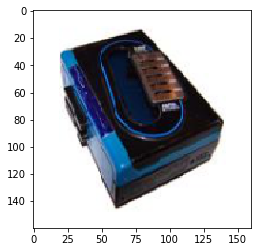

In [ ]:
for x in range(3):
  matplotlib.pyplot.imshow(train_generator.next()[0][x])


### Training model

Create the base (Convolutional) portion of a VGG model

In [ ]:
base = tf.keras.applications.vgg16.VGG16(include_top=False,
                                         weights='imagenet',
                                         input_tensor=None,
                                         input_shape=(160,160,3),
                                         pooling=None,
                                         classes=10)


1.   Create a Sequential model and add base model from above
2.   Freeze VGG16 weights
3.   Add a Flatten layer and a few Dense layers
4.   Choose optimizer and compile model 


In [ ]:
def make_model():
  #1
  model = tf.keras.models.Sequential()
  model.add(base)
  #2
  for layer in model.layers:
    layer.trainable = False
  #3
  model.add(tf.keras.layers.Flatten())
  model.add(tf.keras.layers.Dense(1000, activation='relu'))
  model.add(tf.keras.layers.Dense(1000, activation='relu'))
  model.add(tf.keras.layers.Dense(10,activation = 'softmax'))
  #4
  opt = tf.keras.optimizers.Adam(learning_rate=0.001)
  model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
  return model
model = make_model()

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 5, 5, 512)         14714688  
_________________________________________________________________
flatten_2 (Flatten)          (None, 12800)             0         
_________________________________________________________________
dense_6 (Dense)              (None, 1000)              12801000  
_________________________________________________________________
dense_7 (Dense)              (None, 1000)              1001000   
_________________________________________________________________
dense_8 (Dense)              (None, 10)                10010     
Total params: 28,526,698
Trainable params: 13,812,010
Non-trainable params: 14,714,688
_________________________________________________________________


Train

In [ ]:
history = model.fit_generator(train_generator,
                              steps_per_epoch = train_generator.samples/ 100,
                              epochs=5,
                              validation_data=val_generator,
                              validation_steps = val_generator.samples/50,
                              verbose=1)

Epoch 1/5
129/128 [==============================] - 263s 2s/step - loss: 0.7955 - accuracy: 0.7605 - val_loss: 0.3383 - val_accuracy: 0.9000
Epoch 2/5
129/128 [==============================] - 262s 2s/step - loss: 0.3688 - accuracy: 0.8751 - val_loss: 0.3789 - val_accuracy: 0.8860
Epoch 3/5
129/128 [==============================] - 262s 2s/step - loss: 0.2720 - accuracy: 0.9097 - val_loss: 0.2964 - val_accuracy: 0.9060
Epoch 4/5
129/128 [==============================] - 262s 2s/step - loss: 0.1886 - accuracy: 0.9363 - val_loss: 0.3692 - val_accuracy: 0.8780
Epoch 5/5
129/128 [==============================] - 262s 2s/step - loss: 0.1552 - accuracy: 0.9470 - val_loss: 0.4254 - val_accuracy: 0.8920


Graph results

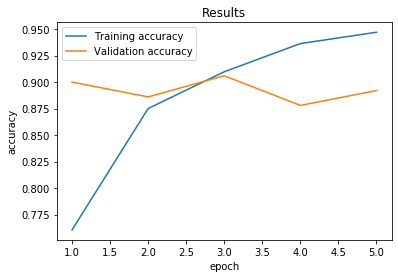

In [ ]:
import matplotlib.pyplot as plt

plt.plot(range(1,6), history.history['accuracy'],label="Training accuracy")
plt.plot(range(1,6), history.history['val_accuracy'], label = "Validation accuracy")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.title("Results")

plt.legend()
plt.show()

Seems like the model starts overfitting after third epoch, so I will run again with only 3 epochs

In [ ]:
history = model.fit_generator(train_generator,
                              steps_per_epoch = train_generator.samples/ 100,
                              epochs=3,
                              validation_data=val_generator,
                              validation_steps = val_generator.samples/50,
                              verbose=1)

Epoch 1/3
129/128 [==============================] - 263s 2s/step - loss: 0.9095 - accuracy: 0.7509 - val_loss: 0.4044 - val_accuracy: 0.8800
Epoch 2/3
129/128 [==============================] - 262s 2s/step - loss: 0.3448 - accuracy: 0.8882 - val_loss: 0.3008 - val_accuracy: 0.9020
Epoch 3/3
129/128 [==============================] - 262s 2s/step - loss: 0.2604 - accuracy: 0.9128 - val_loss: 0.3590 - val_accuracy: 0.8960


graph the final results

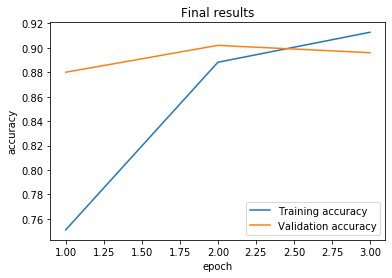

In [ ]:
import matplotlib.pyplot as plt

plt.plot(range(1,4), history.history['accuracy'],label="Training accuracy")
plt.plot(range(1,4), history.history['val_accuracy'], label = "Validation accuracy")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.title("Final results")

plt.legend()
plt.show()

**Average validation loss between the three epochs is 89.2%**

### Documentation of used materials

https://pypi.org/project/wget/ --> learn how to use wget on python

https://stackoverflow.com/questions/30887979/i-want-to-create-a-script-for-unzip-tar-gz-file-via-python --> learn how to unzip tgz file

https://keras.io/preprocessing/image/ --> documentation of ImageDataGenerator

https://keras.io/preprocessing/image/#flow --> documentation of  flow_from_directory

https://keras.io/applications/#vgg16 --> documentation of VGG16

https://keras.io/layers/core/#flatten --> documentation of flatten layers

https://keras.io/layers/core/#dense --> documentation of Denes layers

https://keras.io/models/model/#compile -- > documentation of compile

https://keras.io/models/model/#fit_generator --> documentation of fit_generator

https://keras.io/getting-started/faq/#how-can-i-freeze-keras-layers --> how to freeze pretrained weights